# **CS5658 Anomaly Detection Homework3 – Industrial Anomaly Detection**

## Due Date:  5/2 23:30

#### MVTec AD dataset
MVTec AD is a benchmark dataset for industrial anomaly detection tasks. It contains 15 industrial product classes with over 5000 images in total. The dataset is designed to perform image anomaly detection and segmentation tasks. There are normal / defect images for each class, with ground truth masks provided for the defect samples.


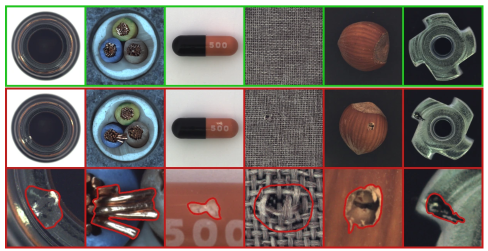

### SimpleNet
SimpleNet is a deep learning model proposed in CVPR 2023. It trains a simple MLP by classifying noisy features from normal features and using it as a discriminator to classify whether a feature is anomaly or not.

Reference: SimpleNet, CVPR 2023

Paper: https://openaccess.thecvf.com/content/CVPR2023/papers/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.pdf

Github: https://github.com/DonaldRR/SimpleNet

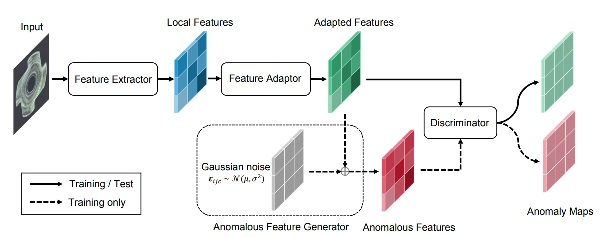


# Problem Setting
In this homework, we will choose two classes in MVTecAD: `metal_nut` and `leather` to perform anomaly detection and segmentation task. You need to implement SimpleNet method by your own, then inference on the two classes. We will use SimpleNet as our architecture, but for the simplicity and training speed, we've made a little adjustments.

* Ignore average pooling in constructing multi-scale feature map
* Use layers [2,3] of WideResNet50
* Epoch reduced from 40 to 20
* Ignore learning rate scheduler
* Discriminator outputs anomaly score instead of normal score

Please implement adaptor and discriminator using the assigned learning rate as follow.
```
adaptor_lr = 1e-3
discriminator_lr = 2e-4
```

Please use **pretrained WideResNet 50** as your feature extractor.

# 1.Download Dataset

!gdown 1vFb_AWIK6nh8BRhRQLM96q2nUqPHsdAR
!unzip mvtec.zip

# 2.Prepare Environment

1.Install needed modules

!pip install einops

2.Import needed modules and set random seed to ensure that results
are consistent every time executed.

In [1]:
from torchvision.models import wide_resnet50_2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
from einops import rearrange
from tqdm.notebook import tqdm
import os
from sklearn.preprocessing import minmax_scale

#########################################
# prepare environment
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

seed_everything(9999)

# 3.Prepare Dataset

In [2]:
#######################################
# prepare dataset
class MVTecDataset(Dataset):
    def __init__(self, mvtec_folder_path='./mvtec', class_name='leather', is_train=True,
                 few_shot=16,resize=256):
        self.class_name        = class_name
        self.is_train          = is_train
        self.resize            = resize
        self.mvtec_folder_path = mvtec_folder_path
        self.few_shot          = few_shot
        # set transforms
        self.transform_x = T.Compose([T.Resize(resize,interpolation=T.InterpolationMode.BILINEAR),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
        self.transform_mask = T.Compose([T.Resize(resize, interpolation=T.InterpolationMode.NEAREST),
                                         T.ToTensor()])
        # load dataset
        self.x, self.y, self.mask = self.load_dataset_folder()
        phase = 'training' if self.is_train else 'testing'
        print(f"{self.class_name} {phase} dataset created, consists of {len(self.x)} images")


    def __getitem__(self, idx):
        x, y, mask = self.x[idx], self.y[idx], self.mask[idx]
        return x, y, mask

    def __len__(self):
        return len(self.x)

    def load_dataset_folder(self):
        phase = 'train' if self.is_train else 'test'
        x, y, mask = [], [], []
        img_dir   = os.path.join(self.mvtec_folder_path, self.class_name, phase)
        gt_dir    = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')
        img_types = sorted(os.listdir(img_dir))
        for img_type in img_types: 
            # load images
            img_type_dir = os.path.join(img_dir, img_type)
            if not os.path.isdir(img_type_dir):
                continue
            img_fpath_list = sorted([os.path.join(img_type_dir, f)
                                     for f in os.listdir(img_type_dir)
                                     if f.endswith('.png')])
            x.extend(img_fpath_list)
            # load gt labels
            if img_type == 'good':
                y.extend([0] * len(img_fpath_list))
                mask.extend([None] * len(img_fpath_list))
            else:
                y.extend([1] * len(img_fpath_list))
                gt_type_dir = os.path.join(gt_dir, img_type)
                img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
                gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png')
                                 for img_fname in img_fname_list]
                mask.extend(gt_fpath_list)

        assert len(x) == len(y), 'number of x and y should be same'

        if self.few_shot is not None and phase=='train':
            # pick images according to few_shot number
            chosen_idx = random.sample(list(range(len(x))),k=self.few_shot)
            x = [x[i] for i in chosen_idx]
            y = [y[i] for i in chosen_idx]
            mask = [mask[i] for i in chosen_idx]

        return [self.transform_x(Image.open(x).convert('RGB')).cuda() for x in list(x)], \
                list(y), \
                [torch.zeros([1, self.resize, self.resize]).cuda() if y==0 else self.transform_mask(Image.open(mask)).cuda() for y,mask in zip(list(y),list(mask))]


# 4.Load & Prepare Feature Extractor

In [3]:

#######################################
# load & prepare model (wide_resnet50_2)
encoder = wide_resnet50_2(pretrained=True, progress=True).cuda()
encoder.eval()
# set hook function to get features
outputs = list()
def hook(module, input, output):
    outputs.append(output)

def get_features(model,img,outputs):
    with torch.no_grad():
            _ = model(img.cuda())
    layer1_feature = outputs[0]
    layer2_feature = outputs[1]
    layer3_feature = outputs[2]
    outputs.clear()
    return [layer1_feature,layer2_feature,layer3_feature]

encoder.layer1.register_forward_hook(hook)
encoder.layer2.register_forward_hook(hook)
encoder.layer3.register_forward_hook(hook)

/home/nthukwh/anaconda3/envs/tf_2.6/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nthukwh/anaconda3/envs/tf_2.6/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 5.Define Our Function to Produce Multi-Scale Feature Map (TODO Q1)

## TODO Q1
In this section, you need to produce multi-scale feature map in this function.</br></br>
The procedure is listed below:</br>
1. Choose a size to resize to, for example, size of second layers as our target size.</br>
1. Resize all features to the target size and store them.</br>
1. Concatenate them all together and return the result.</br>

You need to finish the step2 above, that is, resize `features[i]` to the target size and assign to `temp_feature`.</br>
For example, if the `target_size` is 32, and `features[i]` have size `(batch, channel, width, height)`, the `temp_feature` should have size `(batch, channel, 32, 32)`




In [4]:
import torch.nn.functional as F
#######################################
# produce multi-scale feature
def concat_feature(features,use_layers=None):
    use_layers = [i-1 for i in use_layers]
    # determine resize to which feature
    target_size = features[1].size()[3] # 32
    resized_feature = list()

    for i in range(len(features)):
        current_size = features[i].size()[3]

        ## TODO ######################################################
        # please calculate the factor or size to resize to
        # use F.interpolate() to resize, set mode to bilinear
        # align_corners to False.
        # For more instruction, please refer to :
        # https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html

        temp_feaure = F.interpolate(features[i], size=target_size, mode='bilinear', align_corners=False)
        #############################################################
        resized_feature.append(temp_feaure)

    return torch.concat([resized_feature[i] for i in use_layers],dim=1)

# 6.Define The Adaptor & Discriminator Of Our Model (TODO Q2)

## TODO Q2
- In this section, you need to design a MLP as the Adaptor.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `out_channel` as its channel dimention.</br>
- Implement **the same Adaptor** in SimpleNet paper.
NOTE: the MLP should not be very complex, you can design a simple one, check the result, and determine if it needs to be more complex. </br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. your image-AUC of both classes must be greater than 0.8.</br>
***layers = Linear -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension, add Dropout layer, etc. </br>

In [5]:
def init_weight(m):

    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
    elif isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)

# Implement the same Adaptor in SimpleNet
class Adaptor(torch.nn.Module):
    
    def __init__(self, in_planes, out_planes=None, n_layers=1, layer_type=0):
        super(Adaptor, self).__init__()
        
        if out_planes is None:
            out_planes = in_planes
        self.layers = torch.nn.Sequential()
        _in = None
        _out = None
        for i in range(n_layers):
            _in = in_planes if i == 0 else _out
            _out = out_planes 
            self.layers.add_module(f"{i}fc", 
                                   torch.nn.Linear(_in, _out))
            if i < n_layers - 1:
                # if layer_type > 0:
                #     self.layers.add_module(f"{i}bn", 
                #                            torch.nn.BatchNorm1d(_out))
                if layer_type > 1:
                    self.layers.add_module(f"{i}relu",
                                           torch.nn.LeakyReLU(.2))
        
        # self.apply(init_weight)

    def forward(self, x):
        batch_size = x.size(0)
        feature_channel = x.size(1) # 1536
        x = x.permute(0,2,3,1)
        x = x.view(batch_size, -1, feature_channel)
        # x = x.transpose(1, 3).transpose(1, 2)
        # x = .1 * self.layers(x) + x
        x = self.layers(x)
        x = x.view(-1, feature_channel)
        return x

- In this section, you need to design a MLP as the Discriminator's body.</br>
- The MLP should takes in a tensor with `in_channel` as its channel dimention, and outputs a tensor with `mid_channel` as its channel dimention.</br>
- First, implement **the same Discriminator** in SimpleNet paper.
- Second, design your own version of Discriminator with **fewer model parameters to approach the SimpleNet performance**. You need to try **TWO** kinds of model settings. </br>
NOTE: the Discriminator should involve at least one BatchNormalization layer.</br></br>

---


**HINT:** A good design should result in Image-AUC=0.95 for leather, Image-AUC=0.95 for metal_nut in Sec.13. It's OK to get lower score than default, but image-AUC of both classes must be greater than 0.8.</br>
***Body = Linear -> BatchNorm1d -> LeakyReLU(0.2)***</br>
Things you can change: number of layers, activation function, number of hidden dimension (`mid_channel`), add Dropout layer, etc. </br>


In [6]:
# Implement the same Discriminator in SimpleNet
class Discriminator(torch.nn.Module):
    def __init__(self, in_planes, n_layers=2, hidden=None):
        super(Discriminator, self).__init__()

        _hidden = in_planes if hidden is None else hidden
        self.body = torch.nn.Sequential()
        for i in range(n_layers-1):
            _in = in_planes if i == 0 else _hidden
            _hidden = int(_hidden // 1.5) if hidden is None else hidden
            self.body.add_module('block%d'%(i+1),
                                 torch.nn.Sequential(
                                     torch.nn.Linear(_in, _hidden),
                                     torch.nn.BatchNorm1d(_hidden),
                                     torch.nn.LeakyReLU(0.2)
                                 ))
        self.tail = torch.nn.Linear(_hidden, 1, bias=False)
        # self.apply(init_weight)

    def forward(self,x):
        # print("before", x.shape)
        x = self.body(x)
        # print("body", x.shape)
        x = self.tail(x)
        # print("tail", x.shape)
        return x
    
# Implement your own Discriminator with fewer model parameters
class Var_Discriminator(torch.nn.Module):
    def __init__(self, in_planes, n_layers=2, hidden=None, dropout=True):
        super(Var_Discriminator, self).__init__()

        _hidden = in_planes if hidden is None else hidden
        self.body = torch.nn.Sequential()
        for i in range(n_layers-1):
            _in = in_planes if i == 0 else _hidden
            _hidden = int(_hidden // 1.5) if hidden is None else hidden
            if dropout:
                self.body.add_module('drop out%d'%(i+1),torch.nn.Dropout(p=0.5))
            self.body.add_module('block%d'%(i+1),
                                 torch.nn.Sequential(
                                     torch.nn.Linear(_in, _hidden),
                                     torch.nn.BatchNorm1d(_hidden),
                                     torch.nn.ReLU()
                                 ))
        self.tail = torch.nn.Linear(_hidden, 1, bias=False)
        # self.apply(init_weight)

    def forward(self,x):
        # print("before", x.shape)
        x = self.body(x)
        # print("body", x.shape)
        x = self.tail(x)
        # print("tail", x.shape)
        return x

        

# 7.Define Our Whole Model (SimpleNet)

In [7]:
#######################################
# define our model (simplenet)
class Simplenet(nn.Module):
    def __init__(self,in_channel, dropout=True, use_variation=False):
        super(Simplenet,self).__init__()
        self.adaptor = Adaptor(in_channel, in_channel)
        if use_variation:
            self.discriminator = Var_Discriminator(in_channel, dropout=dropout)
        else:
            self.discriminator = Discriminator(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

# 8.Define The Training Process

In [8]:
def train_one_epoch(encoder,simplenet,adaptor_optim,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        scores = simplenet(features)
        true_scores = scores[:features.size()[0]*features.size()[2]*features.size()[3]]
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 #margin
        true_loss = torch.clip(true_scores + th, min=0)
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = true_loss.mean() + fake_loss.mean()
        total_loss+=loss

        # clear gradient
        adaptor_optim.zero_grad()
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        adaptor_optim.step()
        discriminator_optim.step()
    return total_loss

# 9.Define The Testing Process

In [9]:
#######################################
# testing
@torch.no_grad()
def test(encoder,simplenet,dataset,use_layers,batch_size):
    result = dict()
    result['total_scores_pixel'] = list()
    result['total_scores_image'] = list()
    result['total_gt_pixel'] = list()
    result['total_gt_image'] = list()
    # result['features_orig'] = list()
    # result['features_adapted'] = list()
    result['input_image'] = list()


    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        simplenet.eval()
        # store input image
        result['input_image'].append(x.cpu().detach().numpy())
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        # store features before adaptor
        # result['features_orig'].append(rearrange(features,'b c h w -> (b h w) c').cpu().detach().numpy())
        size = features.size()
        scores,true_feats = simplenet.predict(features)
        # store features after adaptor
        # result['features_adapted'].append(true_feats.cpu().detach().numpy())

        # calculate and store image-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b (h w)',b=size[0],h=size[3],w=size[2])
        image_score,_ = torch.max(anomaly_score_map,dim=1,keepdim=False)
        result['total_scores_image'].append(image_score.cpu().detach().numpy())

        # calculate and store pixel-level anomaly score
        anomaly_score_map = rearrange(scores,'(b h w) 1 -> b 1 h w',b=size[0],h=size[3],w=size[2])
        anomaly_score_map = F.interpolate(anomaly_score_map,
                                        size=(x.size()[2],x.size()[3]),
                                        mode="bilinear",
                                        align_corners=False)
        anomaly_score_1d = rearrange(anomaly_score_map,'b c h w -> (b c h w)')
        result['total_scores_pixel'].append(anomaly_score_1d.cpu().detach().numpy())

        # store groundtruth
        mask_1d = rearrange(mask,'b c h w -> (b c h w)')
        result['total_gt_pixel'].append(mask_1d.cpu().detach().numpy())
        result['total_gt_image'].append(y.cpu().detach().numpy())

    # gether all scores and groundtruth
    # result['input_image'] = np.concatenate(result['input_image'],axis=0)
    result['total_scores_pixel'] = np.hstack(result['total_scores_pixel'])
    result['total_scores_image'] = np.hstack(result['total_scores_image'])
    result['total_gt_pixel'] = np.hstack(result['total_gt_pixel'])
    result['total_gt_image'] = np.hstack(result['total_gt_image'])

    # gether all extracted features
    # result['features_orig'] = np.concatenate(result['features_orig'],axis=0)
    # result['features_adapted'] = np.concatenate(result['features_adapted'],axis=0)

    # min-max normalization on scores
    result['total_scores_pixel'] = minmax_scale(result['total_scores_pixel'])
    result['total_scores_image'] = minmax_scale(result['total_scores_image'])

    simplenet.train()
    return result

# 10.Define Functions That Calculate And Show ROC & AUROC (TODO Q3)

## TODO Q3
In this section, you need to define the function to calculate false-positive rate, true-positive rate and area-under ROC by the scores and the groundtruth labels and assign them to `fpr`, `tpr`, `auc` respectively.

In [10]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

def compute_retrieval_metrics(pred, true, title, label=None):
    fpr, tpr, _ = roc_curve(true, pred)
    auroc = auc(fpr, tpr)
    curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auroc, estimator_name=label)
    curve.plot()
    plt.title(title)
    plt.show()
    
    return fpr, tpr, auroc

# 11.Define Other Utility Functions (if Needed)

In [11]:
class Model:
    def __init__(self, class_name, dropout=True, use_variation=False):
        self.model = Simplenet(in_channel=1536, dropout=dropout, use_variation=use_variation).cuda()
        self.adaptor_opt = torch.optim.AdamW(self.model.adaptor.parameters(), adaptor_lr*.1)
        self.discriminator_opt = torch.optim.Adam(self.model.discriminator.parameters(), lr=discriminator_lr)
        
        self.class_name = class_name
        self.train_dataset = MVTecDataset(class_name=self.class_name)
        self.test_dataset = MVTecDataset(class_name=self.class_name, is_train=False)
        
        self.result = dict()
        self.acc = dict()
        
        self.num_params = sum(p.numel() for p in self.model.parameters())
    
    def append_result(self, result):
        self.result = result
        
    def append_acc(self, acc):
        self.acc = acc

def plot_compare(orig_models, variation_models):
    # plot original model
    for model in orig_models:
        plt.scatter(model.num_params, model.acc['auroc_image'], c='k')
        
    for model in variation_models:
        plt.scatter(model.num_params, model.acc['auroc_image'], c='b')
    
    plt.title("Parameters-ROC(image)")
    plt.ylabel("AUROC Performance(image-wise)")
    plt.xlabel("# of Parameters(M)")
    plt.grid(True)
    plt.show()

# 12.Setup Training Parameters

Setup learning rate, total epoch, layers to used, SimpleNet and optimizer for both class.

In [12]:
# Training parameters
adaptor_lr = 1e-3
discriminator_lr = 2e-4
epochs = 20

# Define use_layers
use_layers = [2,3]
# Create SimpleNet and optimizer for both classes
leather_orig_simplenet = Model(class_name='leather')
leather_vari_simplenet = Model(class_name='leather',dropout=True, use_variation=True)
leather_wo_drop_simplenet = Model(class_name='leather',dropout=False, use_variation=True)

metal_nut_orig_simplenet = Model(class_name='metal_nut')
metal_nut_vari_simplenet = Model(class_name='metal_nut',dropout=True, use_variation=True)
metal_nut_wo_drop_simplenet = Model(class_name='metal_nut',dropout=False, use_variation=True)
Models = [leather_orig_simplenet, 
          leather_vari_simplenet, 
          leather_wo_drop_simplenet,
          metal_nut_orig_simplenet, 
          metal_nut_vari_simplenet, 
          metal_nut_wo_drop_simplenet]
Names = ["leather_original", 
         "leather_variation", 
         "leather_WO_dropout",
         "metal_nut_original", 
         "metal_nut_variation", 
         "metal_nut_WO_dropout"]

# simplenet = Simplenet(in_channel=1536,dropout=True, use_variation=True).cuda()
# adaptor_opt = torch.optim.AdamW(simplenet.adaptor.parameters(), adaptor_lr*.1)
# discriminator_opt = torch.optim.Adam(simplenet.discriminator.parameters(), lr=discriminator_lr)

# train_dataset = MVTecDataset(class_name='leather')
# test_dataset = MVTecDataset(class_name='leather', is_train=False)

leather training dataset created, consists of 16 images
leather testing dataset created, consists of 124 images
leather training dataset created, consists of 16 images
leather testing dataset created, consists of 124 images
leather training dataset created, consists of 16 images
leather testing dataset created, consists of 124 images
metal_nut training dataset created, consists of 16 images
metal_nut testing dataset created, consists of 115 images
metal_nut training dataset created, consists of 16 images
metal_nut testing dataset created, consists of 115 images
metal_nut training dataset created, consists of 16 images
metal_nut testing dataset created, consists of 115 images


# 13.Start Training & Testing (TODO Q4)

## TODO Q4
Write your training / testing code and plot ROC curve.

start training


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 leather_original Loss : 4.881359
epoch 1 leather_original Loss : 0.970714
epoch 2 leather_original Loss : 0.172451
epoch 3 leather_original Loss : 0.042220
epoch 4 leather_original Loss : 0.020893
epoch 5 leather_original Loss : 0.012051
epoch 6 leather_original Loss : 0.007003
epoch 7 leather_original Loss : 0.003540
epoch 8 leather_original Loss : 0.002737
epoch 9 leather_original Loss : 0.001431
epoch 10 leather_original Loss : 0.000614
epoch 11 leather_original Loss : 0.000780
epoch 12 leather_original Loss : 0.001036
epoch 13 leather_original Loss : 0.000787
epoch 14 leather_original Loss : 0.000921
epoch 15 leather_original Loss : 0.000476
epoch 16 leather_original Loss : 0.000415
epoch 17 leather_original Loss : 0.000557
epoch 18 leather_original Loss : 0.000402
epoch 19 leather_original Loss : 0.000235
start testing


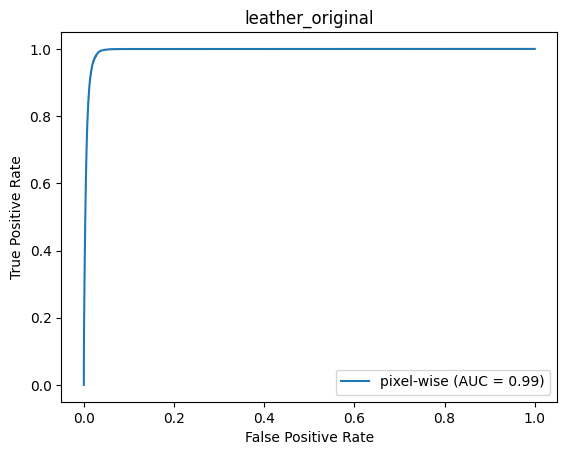

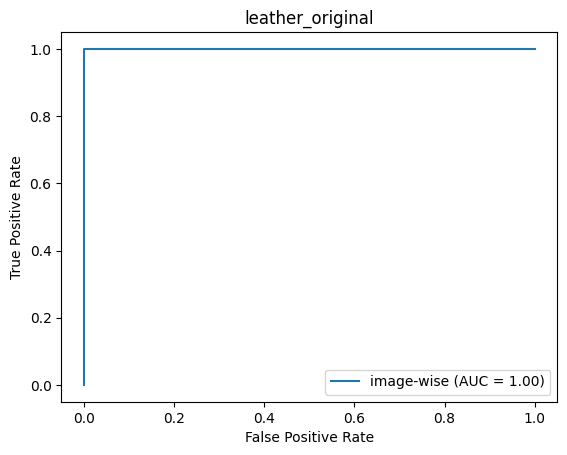

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 leather_variation Loss : 7.887602
epoch 1 leather_variation Loss : 6.889524
epoch 2 leather_variation Loss : 4.899287
epoch 3 leather_variation Loss : 2.472554
epoch 4 leather_variation Loss : 1.351056
epoch 5 leather_variation Loss : 0.836998
epoch 6 leather_variation Loss : 0.562660
epoch 7 leather_variation Loss : 0.416468
epoch 8 leather_variation Loss : 0.322422
epoch 9 leather_variation Loss : 0.248629
epoch 10 leather_variation Loss : 0.202732
epoch 11 leather_variation Loss : 0.172979
epoch 12 leather_variation Loss : 0.149647
epoch 13 leather_variation Loss : 0.131137
epoch 14 leather_variation Loss : 0.117980
epoch 15 leather_variation Loss : 0.103193
epoch 16 leather_variation Loss : 0.098225
epoch 17 leather_variation Loss : 0.090640
epoch 18 leather_variation Loss : 0.084612
epoch 19 leather_variation Loss : 0.078665
start testing


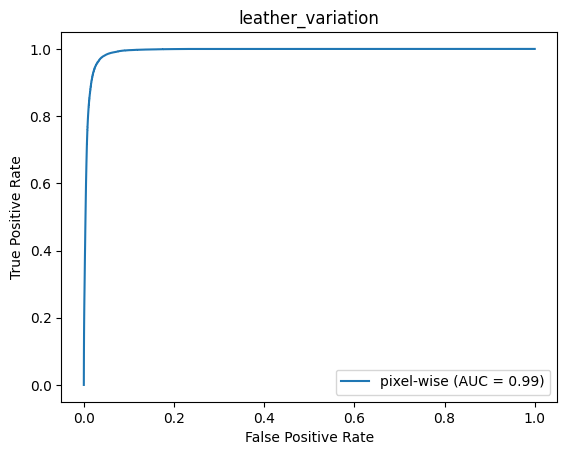

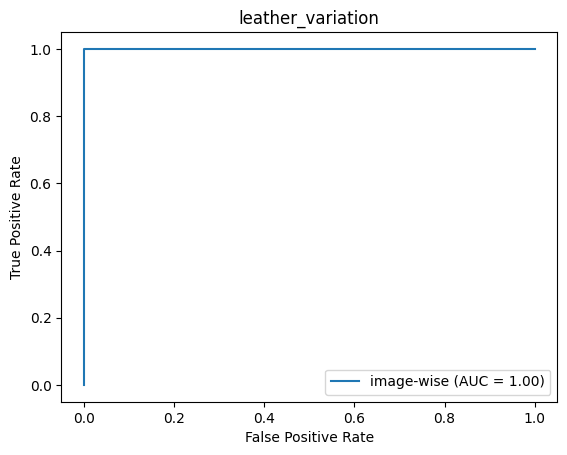

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 leather_WO_dropout Loss : 3.787134
epoch 1 leather_WO_dropout Loss : 0.262959
epoch 2 leather_WO_dropout Loss : 0.055651
epoch 3 leather_WO_dropout Loss : 0.036190
epoch 4 leather_WO_dropout Loss : 0.042238
epoch 5 leather_WO_dropout Loss : 0.051276
epoch 6 leather_WO_dropout Loss : 0.061956
epoch 7 leather_WO_dropout Loss : 0.040705
epoch 8 leather_WO_dropout Loss : 0.016758
epoch 9 leather_WO_dropout Loss : 0.009315
epoch 10 leather_WO_dropout Loss : 0.002615
epoch 11 leather_WO_dropout Loss : 0.001211
epoch 12 leather_WO_dropout Loss : 0.000938
epoch 13 leather_WO_dropout Loss : 0.000333
epoch 14 leather_WO_dropout Loss : 0.000203
epoch 15 leather_WO_dropout Loss : 0.000038
epoch 16 leather_WO_dropout Loss : 0.000246
epoch 17 leather_WO_dropout Loss : 0.000412
epoch 18 leather_WO_dropout Loss : 0.000201
epoch 19 leather_WO_dropout Loss : 0.000327
start testing


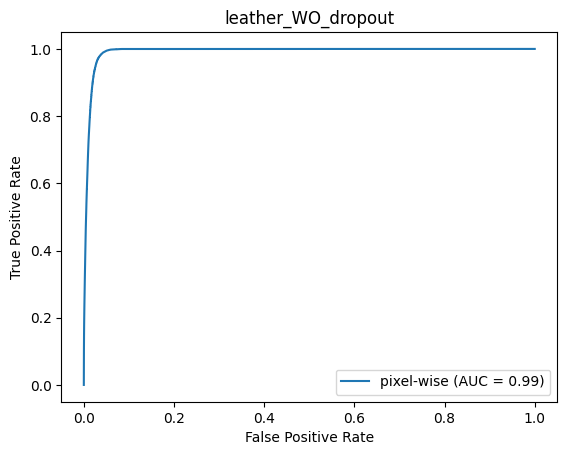

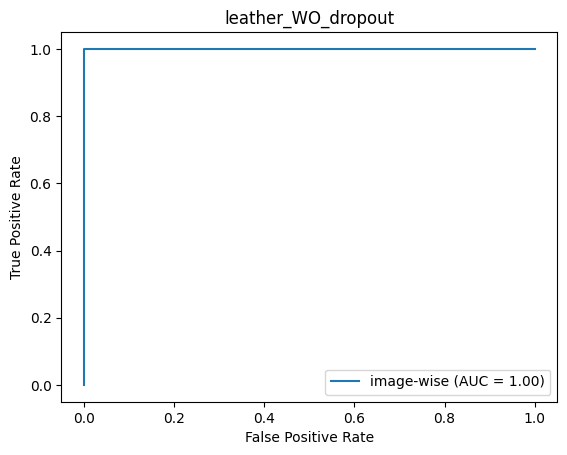

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 metal_nut_original Loss : 5.869209
epoch 1 metal_nut_original Loss : 2.493042
epoch 2 metal_nut_original Loss : 1.553332
epoch 3 metal_nut_original Loss : 0.887716
epoch 4 metal_nut_original Loss : 0.445365
epoch 5 metal_nut_original Loss : 0.308145
epoch 6 metal_nut_original Loss : 0.247046
epoch 7 metal_nut_original Loss : 0.262935
epoch 8 metal_nut_original Loss : 0.250379
epoch 9 metal_nut_original Loss : 0.198569
epoch 10 metal_nut_original Loss : 0.190346
epoch 11 metal_nut_original Loss : 0.127378
epoch 12 metal_nut_original Loss : 0.108769
epoch 13 metal_nut_original Loss : 0.104858
epoch 14 metal_nut_original Loss : 0.094579
epoch 15 metal_nut_original Loss : 0.113312
epoch 16 metal_nut_original Loss : 0.140430
epoch 17 metal_nut_original Loss : 0.248694
epoch 18 metal_nut_original Loss : 0.255367
epoch 19 metal_nut_original Loss : 0.146603
start testing


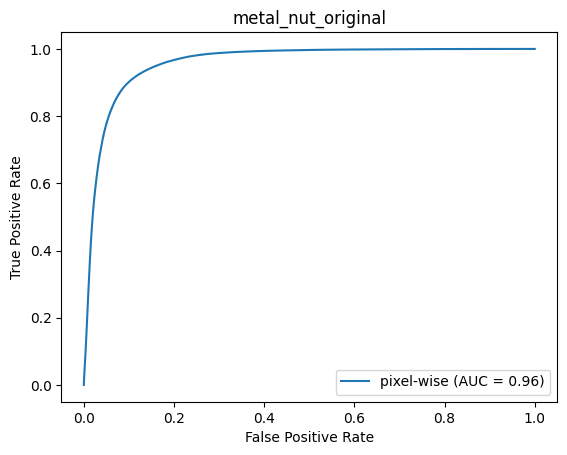

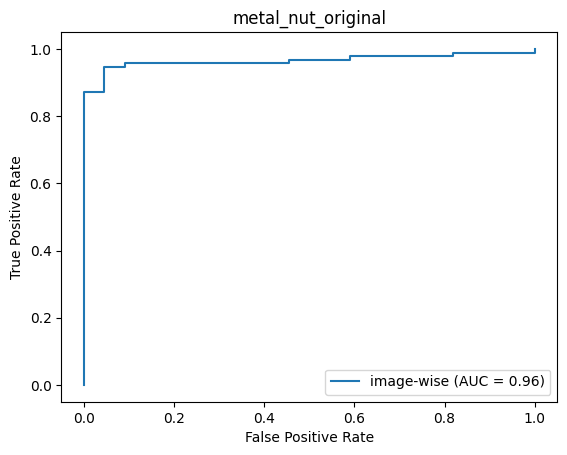

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 metal_nut_variation Loss : 7.832994
epoch 1 metal_nut_variation Loss : 5.886611
epoch 2 metal_nut_variation Loss : 3.663844
epoch 3 metal_nut_variation Loss : 2.440270
epoch 4 metal_nut_variation Loss : 1.979934
epoch 5 metal_nut_variation Loss : 1.677421
epoch 6 metal_nut_variation Loss : 1.386397
epoch 7 metal_nut_variation Loss : 1.145145
epoch 8 metal_nut_variation Loss : 0.963098
epoch 9 metal_nut_variation Loss : 0.834869
epoch 10 metal_nut_variation Loss : 0.707524
epoch 11 metal_nut_variation Loss : 0.645757
epoch 12 metal_nut_variation Loss : 0.569357
epoch 13 metal_nut_variation Loss : 0.506314
epoch 14 metal_nut_variation Loss : 0.462011
epoch 15 metal_nut_variation Loss : 0.408077
epoch 16 metal_nut_variation Loss : 0.389567
epoch 17 metal_nut_variation Loss : 0.327247
epoch 18 metal_nut_variation Loss : 0.315738
epoch 19 metal_nut_variation Loss : 0.291202
start testing


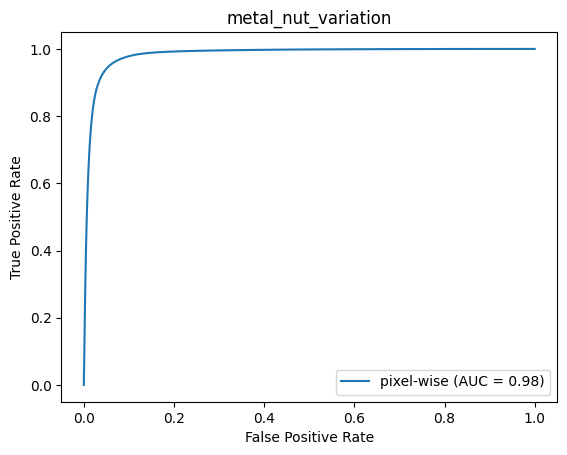

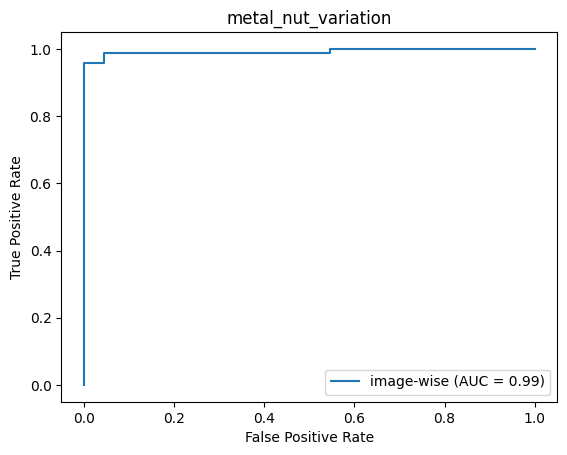

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 metal_nut_WO_dropout Loss : 5.112144
epoch 1 metal_nut_WO_dropout Loss : 1.649956
epoch 2 metal_nut_WO_dropout Loss : 0.615005
epoch 3 metal_nut_WO_dropout Loss : 0.290210
epoch 4 metal_nut_WO_dropout Loss : 0.191617
epoch 5 metal_nut_WO_dropout Loss : 0.222130
epoch 6 metal_nut_WO_dropout Loss : 0.142940
epoch 7 metal_nut_WO_dropout Loss : 0.132955
epoch 8 metal_nut_WO_dropout Loss : 0.094712
epoch 9 metal_nut_WO_dropout Loss : 0.121026
epoch 10 metal_nut_WO_dropout Loss : 0.095735
epoch 11 metal_nut_WO_dropout Loss : 0.093918
epoch 12 metal_nut_WO_dropout Loss : 0.067408
epoch 13 metal_nut_WO_dropout Loss : 0.082157
epoch 14 metal_nut_WO_dropout Loss : 0.079101
epoch 15 metal_nut_WO_dropout Loss : 0.030999
epoch 16 metal_nut_WO_dropout Loss : 0.015417
epoch 17 metal_nut_WO_dropout Loss : 0.008087
epoch 18 metal_nut_WO_dropout Loss : 0.002825
epoch 19 metal_nut_WO_dropout Loss : 0.000778
start testing


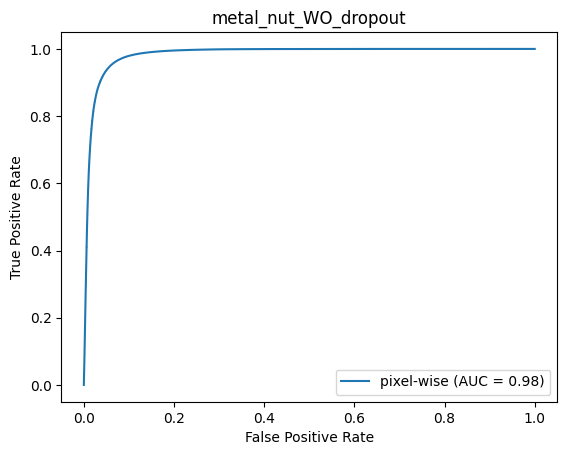

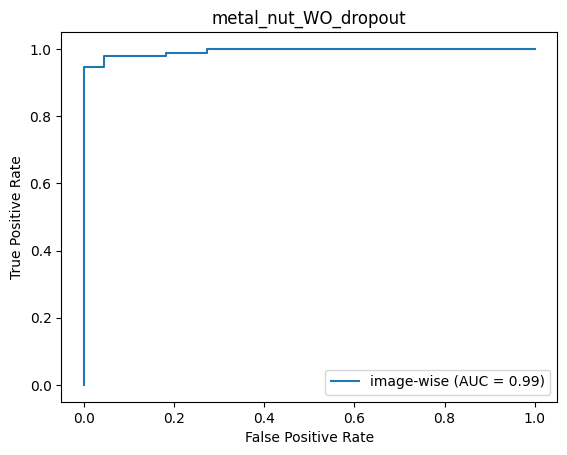

In [13]:
print(f"start training")
for j in range(6):
    for i in tqdm(range(epochs)):
        loss = train_one_epoch(encoder, 
                               Models[j].model, 
                               Models[j].adaptor_opt, 
                               Models[j].discriminator_opt, 
                               Models[j].train_dataset, 
                               use_layers, 
                               2)
        print(f"epoch {i} {Names[j]} Loss : {loss:.6f}")
        
    print(f"start testing")
    acc = dict()
    
    result = test(encoder, Models[j].model, Models[j].test_dataset, use_layers, 1024)
    Models[j].append_result(result)
    _ , _ , acc['auroc_pixel'] = compute_retrieval_metrics(Models[j].result['total_scores_pixel'], Models[j].result['total_gt_pixel'], title=Names[j], label='pixel-wise')
    _ , _ , acc['auroc_image'] = compute_retrieval_metrics(Models[j].result['total_scores_image'], Models[j].result['total_gt_image'], title=Names[j], label='image-wise')
    Models[j].append_acc(acc)
    print("===================================================================")

Calculate & Plot ROC curve

# 15.Plot Parameters-ROC Figure (TODO Q5)


## TODO Q5
* Try different number of parameters in Discriminator, record the performance.
* Plot the figure with `X-axis=Number of SimpleNet Params`, `Y-axis=AUROC Performance`
* Mark the original SimpleNet as `black point`.
* Mark your models with different number of parameters as `blue points`.


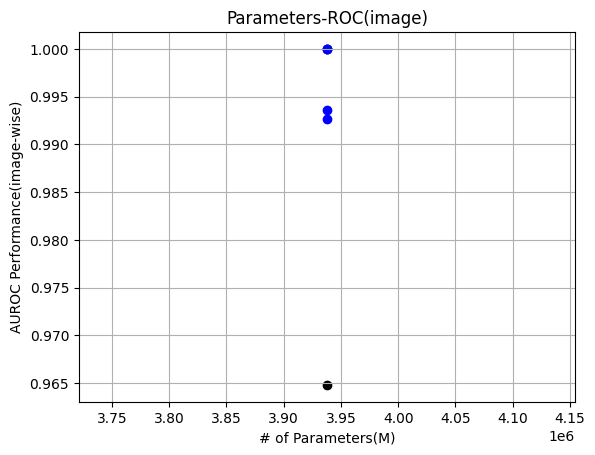

In [14]:
# Use the following code to measure your model parameters
orig_models = [leather_orig_simplenet, metal_nut_orig_simplenet]
variation_models = [metal_nut_vari_simplenet, 
                    metal_nut_wo_drop_simplenet,
                    leather_vari_simplenet, 
                    leather_wo_drop_simplenet]
plot_compare(orig_models, variation_models)

# 15.Show Testing Results (Input & GT mask & anomaly map) (TODO Q6)

## TODO Q6
In this section, you need to choose a threshold for both class to produce a mask from anomaly map, a pixel with a score higher than the threshold is considered as anomaly region. Threshold should be a number between 0 and 1.

Random choose one inference mask for each class and output results.

(Testing Input / Ground Truth Mask / Predict Mask)

In [15]:
def plot_result(model, image_idx, threshold = 0.5):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    # Plot input image
    img = model.result['input_image'][0][image_idx].transpose((1,2,0))
    img = img * std + mean
    plt.imshow(img, interpolation='nearest')
    plt.title("Testing Input")
    plt.show()
    
    size = img.shape
    # Plot Ground-truth Mask
    gt_mask = model.result['total_gt_pixel'][size[0]*size[1]*image_idx : size[0]*size[1]*(image_idx+1)]
    gt_mask = np.reshape(gt_mask, (size[0], size[1]))
    plt.imshow(gt_mask, interpolation='nearest', cmap='gray')
    plt.title("Ground Truth Mask")
    plt.show()
    # Plot Prediction
    pred = model.result['total_scores_pixel'][size[0]*size[1]*image_idx : size[0]*size[1]*(image_idx+1)]
    pred = np.reshape(pred, (size[0], size[1]))
    pred = np.where(pred > threshold, 1, 0)
    plt.imshow(pred, interpolation='nearest')
    plt.title("Predict Mask")
    plt.show()
    

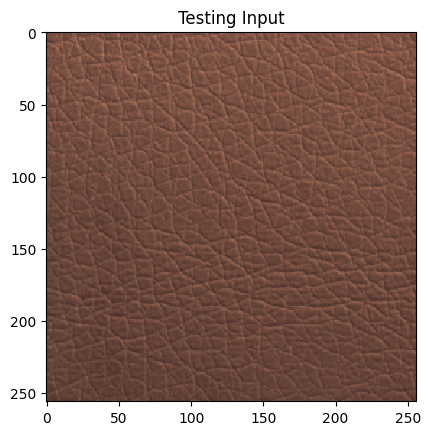

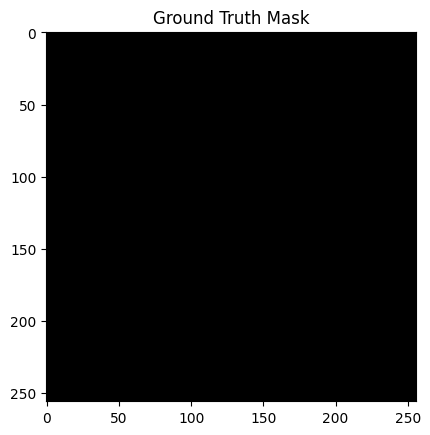

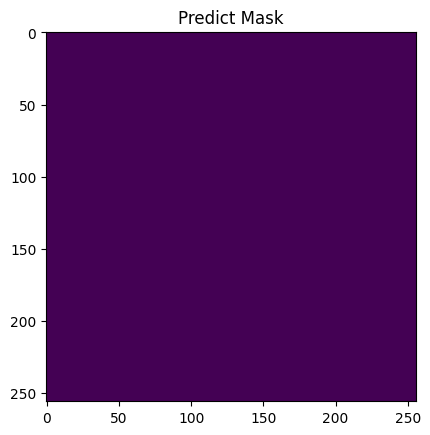

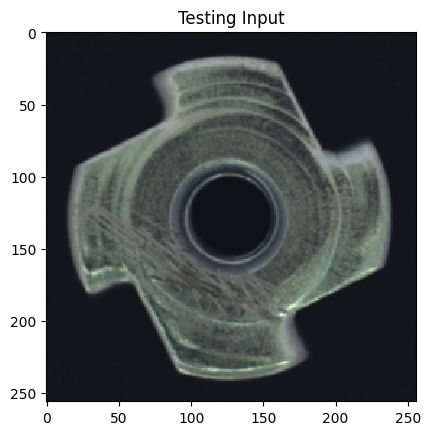

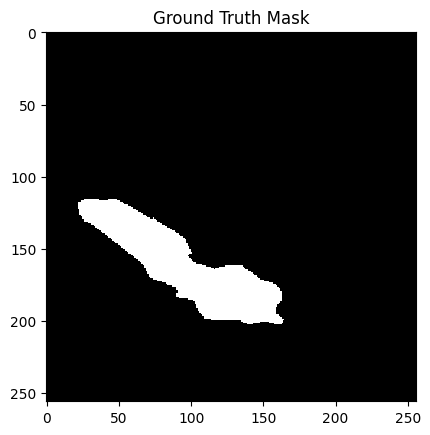

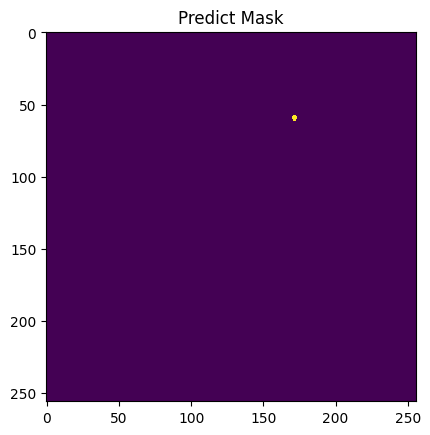

In [16]:
thresholds = [0.5, 0.5]
models = [leather_orig_simplenet, metal_nut_orig_simplenet]
for threshold, model in zip(thresholds, models):
    data_len = model.result['input_image'][0].shape[0]
    image_idx = np.random.randint(0, data_len)
    plot_result(model, image_idx, threshold)

In [17]:
for i in range(6):
    Models[i].result.clear()
    Models[i].acc.clear()

# 16.Ablation Study (TODO Q7 / Q8)

## TODO Q7
In this section, you need to conduct experiment with and without using the `adaptor`, and record the performance respectively

In [18]:
class Simplenet_WO_Adaptor(nn.Module):
    def __init__(self,in_channel, dropout=True, use_variation=False):
        super(Simplenet_WO_Adaptor,self).__init__()
        if use_variation:
            self.discriminator = Var_Discriminator(in_channel, dropout=dropout)
        else:
            self.discriminator = Discriminator(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * 1.1**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        x = x.permute(0,2,3,1)
        x = x.flatten(start_dim=0, end_dim=2)
        true_feats = x
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        x = x.permute(0,2,3,1)
        x = x.flatten(start_dim=0, end_dim=2)
        true_feats = x
        scores = self.discriminator(true_feats)
        return scores,true_feats
    
def train_one_epoch_wo_adaptor(encoder,simplenet,discriminator_optim,dataset,use_layers,batch_size):
    total_loss = 0
    for x,y,mask in DataLoader(dataset,batch_size=batch_size):
        features = get_features(encoder,x,outputs)
        features = concat_feature(features,use_layers)
        scores = simplenet(features)
        fake_scores = scores[features.size()[0]*features.size()[2]*features.size()[3]:]

        th = 0.5 #margin
        fake_loss = torch.clip(-fake_scores + th, min=0)

        loss = fake_loss.mean()
        total_loss+=loss

        # clear gradient
        discriminator_optim.zero_grad()

        # calculate new gradient
        loss.backward()

        # update parameters
        discriminator_optim.step()
    return total_loss

In [19]:
simplenet_wo_adaptor = Simplenet_WO_Adaptor(in_channel=1536).cuda()
discriminator_opt = torch.optim.Adam(simplenet_wo_adaptor.discriminator.parameters(), lr=discriminator_lr)

leather_train_dataset = MVTecDataset(class_name='leather')
leather_test_dataset = MVTecDataset(class_name='leather', is_train=False)
metal_nut_train_dataset = MVTecDataset(class_name='metal_nut')
metal_nut_test_dataset = MVTecDataset(class_name='metal_nut', is_train=False)

train_datasets = [leather_train_dataset, metal_nut_train_dataset]
test_datasets = [leather_test_dataset, metal_nut_test_dataset]

leather training dataset created, consists of 16 images
leather testing dataset created, consists of 124 images
metal_nut training dataset created, consists of 16 images
metal_nut testing dataset created, consists of 115 images


  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 Loss : 0.637704
epoch 1 Loss : 0.014548
epoch 2 Loss : 0.001412
epoch 3 Loss : 0.000718
epoch 4 Loss : 0.000542
epoch 5 Loss : 0.000183
epoch 6 Loss : 0.000164
epoch 7 Loss : 0.000022
epoch 8 Loss : 0.000023
epoch 9 Loss : 0.000001
epoch 10 Loss : 0.000000
epoch 11 Loss : 0.000058
epoch 12 Loss : 0.000036
epoch 13 Loss : 0.000010
epoch 14 Loss : 0.000000
epoch 15 Loss : 0.000000
epoch 16 Loss : 0.000044
epoch 17 Loss : 0.000010
epoch 18 Loss : 0.000000
epoch 19 Loss : 0.000070
start testing


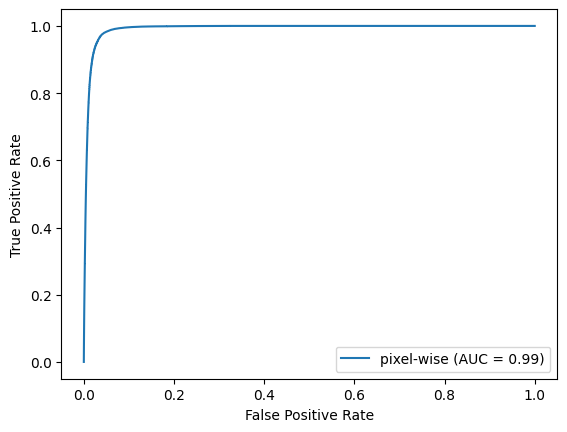

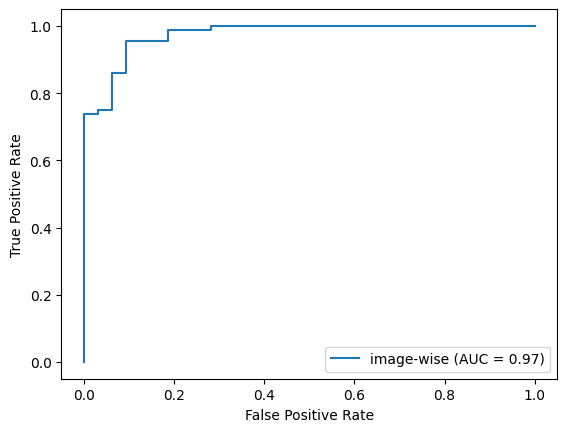

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 Loss : 3.097858
epoch 1 Loss : 0.156685
epoch 2 Loss : 0.007367
epoch 3 Loss : 0.001944
epoch 4 Loss : 0.000624
epoch 5 Loss : 0.000097
epoch 6 Loss : 0.000348
epoch 7 Loss : 0.000000
epoch 8 Loss : 0.000101
epoch 9 Loss : 0.000011
epoch 10 Loss : 0.000000
epoch 11 Loss : 0.000024
epoch 12 Loss : 0.000150
epoch 13 Loss : 0.000007
epoch 14 Loss : 0.000101
epoch 15 Loss : 0.000000
epoch 16 Loss : 0.000232
epoch 17 Loss : 0.000009
epoch 18 Loss : 0.000000
epoch 19 Loss : 0.000074
start testing


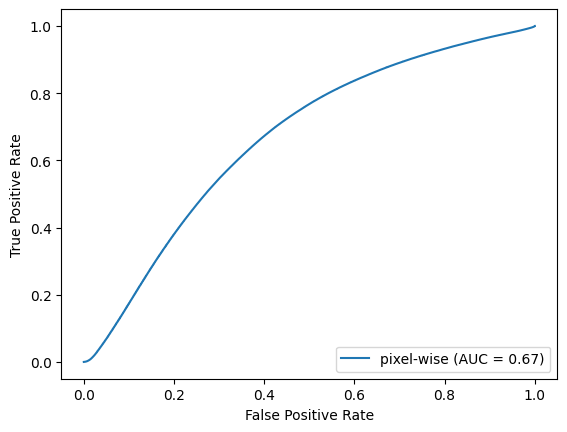

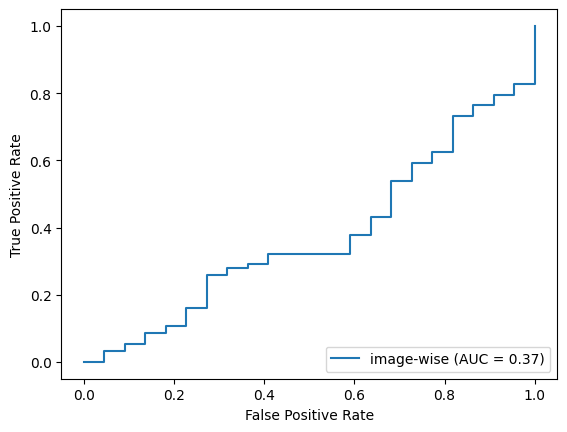

In [20]:
for j in range(2):
    for i in tqdm(range(epochs)):
        loss = train_one_epoch_wo_adaptor(encoder, 
                                simplenet_wo_adaptor, 
                                discriminator_opt, 
                                train_datasets[j], 
                                use_layers, 
                                2)
        print(f"epoch {i} Loss : {loss:.6f}")
        
    print(f"start testing")
    acc = dict()

    result = test(encoder, simplenet_wo_adaptor, test_datasets[j], use_layers, 1024)
    _ , _ , acc['auroc_pixel'] = compute_retrieval_metrics(result['total_scores_pixel'], result['total_gt_pixel'], title=None, label='pixel-wise')
    _ , _ , acc['auroc_image'] = compute_retrieval_metrics(result['total_scores_image'], result['total_gt_image'], title=None, label='image-wise')
    result.clear()
    acc.clear()
    simplenet_wo_adaptor.apply(init_weight)
    print("===================================================================")

## TODO Q8
In this section, you need to conduct experiment with `different scales of the Gaussian noises`. Find the best scale of the noise according to the AUROC performance.

In [21]:
class Simplenet_Noise_Change(nn.Module):
    def __init__(self,in_channel, dropout=True, use_variation=False, noise_coef=1.1):
        super(Simplenet_Noise_Change,self).__init__()
        self.noise_coef = noise_coef
        self.adaptor = Adaptor(in_channel, in_channel)
        if use_variation:
            self.discriminator = Var_Discriminator(in_channel, dropout=dropout)
        else:
            self.discriminator = Discriminator(in_channel)

    def add_noise(self,true_feats):
        noise_idxs = torch.randint(0, 1, torch.Size([true_feats.shape[0]]))
        noise_one_hot = torch.nn.functional.one_hot(noise_idxs, num_classes=1).cuda() # (N, K)
        noise = torch.stack([
            torch.normal(0, 0.05 * self.noise_coef**(k), true_feats.shape)
            for k in range(1)], dim=1).cuda() # (N, K, C)
        noise = (noise * noise_one_hot.unsqueeze(-1)).sum(1)
        return true_feats + noise

    def forward(self,x):
        true_feats = self.adaptor(x)
        fake_feats = self.add_noise(true_feats)
        scores = self.discriminator(torch.cat([true_feats,fake_feats],dim=0))
        return scores

    def predict(self,x):
        true_feats = self.adaptor(x)
        scores = self.discriminator(true_feats)
        return scores,true_feats

In [22]:
simplenet_noise_change = Simplenet_Noise_Change(in_channel=1536, noise_coef=2).cuda()
adaptor_opt = torch.optim.AdamW(simplenet_noise_change.adaptor.parameters(), adaptor_lr*.1)
discriminator_opt = torch.optim.Adam(simplenet_noise_change.discriminator.parameters(), lr=discriminator_lr)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 Loss : 4.509997
epoch 1 Loss : 0.622164
epoch 2 Loss : 0.154846
epoch 3 Loss : 0.049057
epoch 4 Loss : 0.024464
epoch 5 Loss : 0.012340
epoch 6 Loss : 0.013207
epoch 7 Loss : 0.014340
epoch 8 Loss : 0.010907
epoch 9 Loss : 0.016179
epoch 10 Loss : 0.011407
epoch 11 Loss : 0.049681
epoch 12 Loss : 0.013744
epoch 13 Loss : 0.023229
epoch 14 Loss : 0.049872
epoch 15 Loss : 0.015818
epoch 16 Loss : 0.037540
epoch 17 Loss : 0.038782
epoch 18 Loss : 0.043282
epoch 19 Loss : 0.037657
start testing


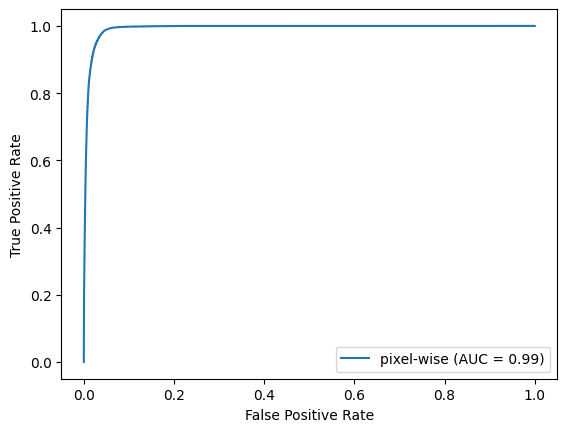

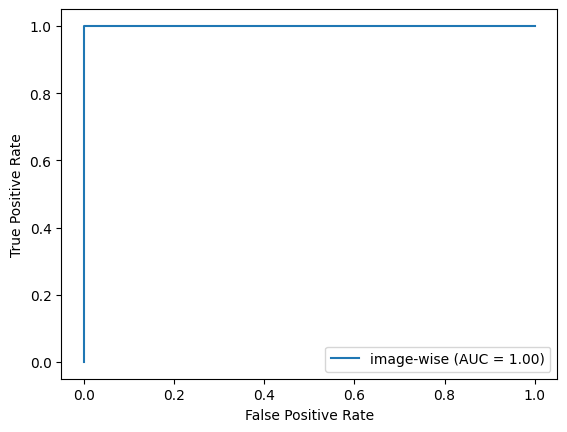

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0 Loss : 9.316507
epoch 1 Loss : 6.181290
epoch 2 Loss : 4.694200
epoch 3 Loss : 5.180280
epoch 4 Loss : 3.175206
epoch 5 Loss : 2.354987
epoch 6 Loss : 1.731876
epoch 7 Loss : 1.482464
epoch 8 Loss : 1.318957
epoch 9 Loss : 1.250491
epoch 10 Loss : 1.358436
epoch 11 Loss : 1.619504
epoch 12 Loss : 1.744374
epoch 13 Loss : 1.512999
epoch 14 Loss : 1.204847
epoch 15 Loss : 1.170373
epoch 16 Loss : 1.300570
epoch 17 Loss : 1.412359
epoch 18 Loss : 1.503561
epoch 19 Loss : 1.214184
start testing


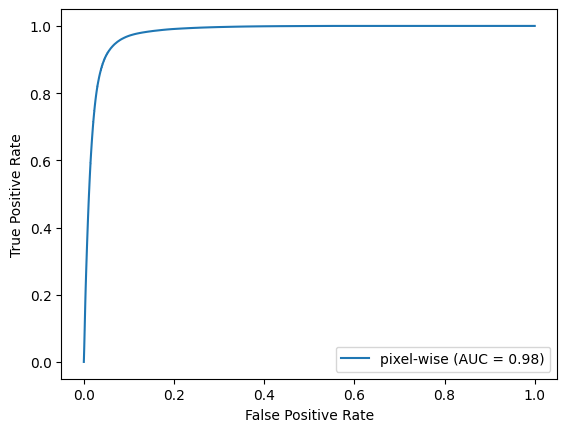

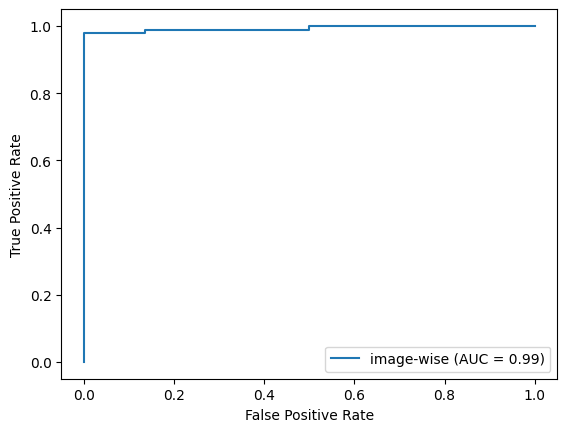

In [23]:
for j in range(2):
    for i in tqdm(range(epochs)):
        loss = train_one_epoch(encoder, 
                                simplenet_noise_change, 
                                adaptor_opt,
                                discriminator_opt, 
                                train_datasets[j], 
                                use_layers, 
                                2)
        print(f"epoch {i} Loss : {loss:.6f}")
        
    print(f"start testing")
    acc = dict()

    result = test(encoder, simplenet_noise_change, test_datasets[j], use_layers, 1024)
    _ , _ , acc['auroc_pixel'] = compute_retrieval_metrics(result['total_scores_pixel'], result['total_gt_pixel'], title=None, label='pixel-wise')
    _ , _ , acc['auroc_image'] = compute_retrieval_metrics(result['total_scores_image'], result['total_gt_image'], title=None, label='image-wise')
    result.clear()
    acc.clear()
    simplenet_noise_change.apply(init_weight)
    print("===================================================================")

# 17.Report (TODO Q9)

Write your observations on the two classes, for example:</br>
Based on the observation, which class is more difficult and why?

### Profile:
- 在我的實驗中，我除了原始的simpleNet之外另外設計了兩種不同的discriminator，這兩個discriminator與原discriminator的差異在於將activation function從leakyReLU改為ReLU，並且其中一個還加入了dropout機制。

- learning rate與epochs皆保持原設定。

### Results:
- 我的訓練包含了三種model(original + variational*2)、兩種datasets，並且accuracy又分為image-wise與pixel-wise，因此共有12種結果。

- 由結果可以觀察到在leather 中三種model的效能皆相差不多。但在matel_nut 中variational model的略勝original model。`因此我推斷這兩個datasets中metal_nut可能比leather更難train一點。`

### Ablation Study
##### 1. Without Adaptor:
移除adaptor後，在leather中可以觀察到image-wise accuracy有稍微下降。而在metal_nut中不論pixel-wise或image-wise皆有顯著下降。這個結果恰好佐證了我們在result的推測:「metal_nut比leather更難訓練」。

##### 2. Change noise scales:
我嘗試將noise scalse從1.1改為2.0，未能從實驗結果中看到顯著變化。